![](https://live.staticflickr.com/65535/52663424849_8939aa98f9_k.jpg)

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mysql.connector as mysql
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
#connecting to the mysql server.
cnx = mysql.connect(
    host="localhost",
    user="root",
    passwd="0710",
    database="gdb041",
    raise_on_warnings=True
)
cursor=cnx.cursor()

In [4]:
#printing all the table_names in the database gdb041
cursor.execute("show tables")
tables=cursor.fetchall()
for i in range(0,len(tables)):
    print(tables[i][0])

dim_customer
dim_product
fact_forecast_monthly
fact_freight_cost
fact_gross_price
fact_manufacturing_cost
fact_post_invoice_deductions
fact_pre_invoice_deductions
fact_sales_monthly


# Data Exploration with SQL

We have the monthly sales data of `AtliQ Hardwares`. Our main goal will be to analyse the sales data and get insights from the sales data. The database `gdb041` is a MySQL database. We will use the mysql connector to python to access the data. We will explore the data using MySQL queries and visualise the insights using the python libraries (matplotlib and seaborn).



#### Tables in the Database `gdb041`

- dim_customer: customer_code, customer, platform, channel, market, sub_zone, region <br>
contains the info about the different customers (Here the customer_code is the primary key. There are customers with many customer_codes.)
- dim_product: product_code, devision, segment, category, product, variant<br>
contains the directory of all the products sold by the firm. (here the product_code is the primary key.)
- fact_forecast_monthly: date, fiscal_year, product_code, customer_code, forecast_quantity<br>
contains the monthly forecast for each product_code (product_code, customer_code are the foregin keys)
- fact_freight_cost: market, fiscal_year,freight_pct, other_cost_pct<br>
contains the freight and other cost of each market and fiscal_year. The freight and other cost are uniform for each product in the particular market and fiscal_year
- fact_gross_price: product_code, fiscal_year, gross_price<br>
contains the gross_price of each product for each fiscal_year
- fact_manufacturing_cost: product_code, cost_year, manufacturing_cost<br>
contains the manufacturing cost of each product for that particular fiscal_year
- fact_post_invoice_deductions: customer_code, product_code, date, discounts_pct, other_deductions_pct<br>
contains the post invoice deductions like discounts on specific product and other deductions
- fact_pre_invoice_deductions: customer_code, fiscal_year, pre_invoice_discount_pct<br>
contains the pre invoice deductions like special discount to a customer for strong relationships.
- fact_sales_monthly: date, product_code, customer_code, sold_quantity<br>
contains the monthly sales data

In [5]:
# dim_customer table
temp_df=pd.read_sql("select * from dim_customer",cnx)
temp_df

,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC
...,...,...,...,...,...,...,...
204,90024183,Electricalsbea Stores,Brick & Mortar,Retailer,Chile,LATAM,LATAM
205,90024184,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM
206,90025209,Electricalsbea Stores,Brick & Mortar,Retailer,Columbia,LATAM,LATAM
207,90026205,Amazon,E-Commerce,Retailer,Mexico,LATAM,LATAM


In [6]:
cursor.execute("select count(distinct customer) from dim_customer")
r1=cursor.fetchall()
cursor.execute("select count(distinct region) from dim_customer")
r2=cursor.fetchall()
print(r1[0][0],",",r2[0][0])

74 , 4


AtliQ Hardwares has a total of 74 different customers spanning over 4 different regions.

In [7]:
# dim_product table
temp_df=pd.read_sql("select * from dim_product",cnx)
temp_df

,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard
...,...,...,...,...,...,...
392,A7220160202,N & S,Networking,Wi fi extender,AQ Wi Power Dx2,Plus
393,A7220160203,N & S,Networking,Wi fi extender,AQ Wi Power Dx2,Premium
394,A7321160301,N & S,Networking,Wi fi extender,AQ Wi Power Dx3,Standard
395,A7321160302,N & S,Networking,Wi fi extender,AQ Wi Power Dx3,Plus


In [8]:
# Total revenue and sold quantity in each fiscal_year
query='''
with cte1 as (select year(date_add(date, interval 4 month)) as fiscal_year, product_code, customer_code, sold_quantity
from fact_sales_monthly)

select fiscal_year, round(sum(sold_quantity)/1000000,2) as total_sold_quantity_in_millions,
    round(sum(sold_quantity*gross_price)/1000000,2) as total_revenue_in_millions
from cte1 
join fact_gross_price
using(product_code, fiscal_year)
group by fiscal_year'''

df1=pd.read_sql(query,cnx)
df1

,fiscal_year,total_sold_quantity_in_millions,total_revenue_in_millions
0,2018,3.45,58.32
1,2019,10.78,209.06
2,2020,20.77,535.95
3,2021,50.16,1664.64
4,2022,40.11,3258.68


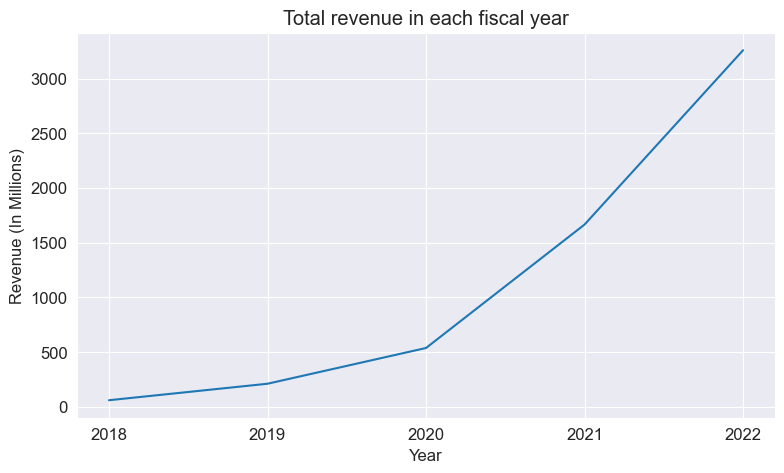

In [9]:
plt.plot(df1.fiscal_year,df1.total_revenue_in_millions)
plt.title('Total revenue in each fiscal year')
plt.xlabel('Year'); plt.ylabel('Revenue (In Millions)');
plt.xticks(df1.fiscal_year, df1.fiscal_year)
plt.show()

We can see that the revenue for AtliQ harwares is increasing rapidly from 2018 to 2022.

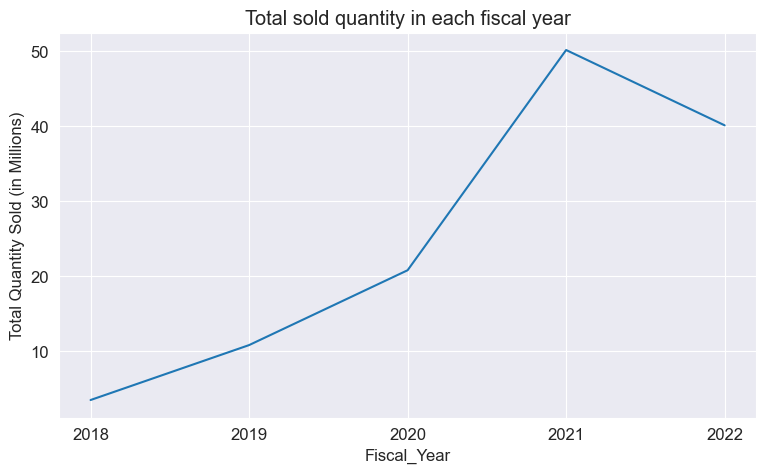

In [10]:
plt.plot(df1.fiscal_year,df1.total_sold_quantity_in_millions)
plt.title('Total sold quantity in each fiscal year')
plt.xlabel('Fiscal_Year')
plt.ylabel('Total Quantity Sold (in Millions)')
plt.xticks(df1.fiscal_year,df1.fiscal_year)
plt.show()

We can see that in the fiscal year 2022 we have sold less quantity of items in comparison to the previous fiscal year 2021. However, we saw that the revenue is quite higher in the fiscal year 2022 than 2021 despite low number of quantities sold.<br>
It may be because of highler sales of items with large price like graphic cards, laptops.

In [11]:
#total revenue and sold quantity in each month
query='''
with cte1 as (select date_format(date,"%b %y") as cdate, 
	date, year(date_add(date, interval 4 month)) as fiscal_year, product_code, customer_code, sold_quantity
	from fact_sales_monthly),
cte2 as (select cdate, date, fiscal_year, round(sum(sold_quantity)/1000000,2) as total_quantity_sold_in_millions, 
		round(sum(sold_quantity*gross_price)/1000000,2) as total_revenue_in_millions
	from cte1 
	join fact_gross_price
	using(product_code, fiscal_year)
	group by 1,2,3
	order by 2)

select cdate as Month, total_quantity_sold_in_millions, total_revenue_in_millions
from cte2
'''
df2=pd.read_sql(query,cnx)
df2.head()

,Month,total_quantity_sold_in_millions,total_revenue_in_millions
0,Sep 17,0.25,4.19
1,Oct 17,0.32,5.30
2,Nov 17,0.44,7.42
3,Dec 17,0.44,7.54
4,Jan 18,0.25,4.19


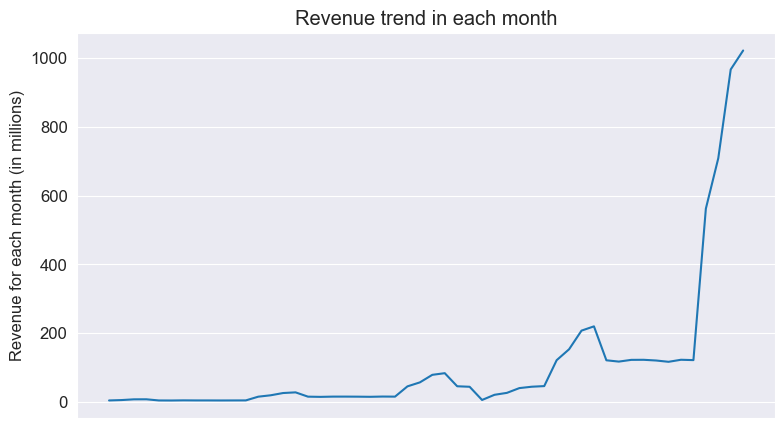

In [12]:
plt.plot(df2.Month,df2.total_revenue_in_millions)
#get current axes
ax = plt.gca()
#hide x-axis
ax.get_xaxis().set_visible(False)
plt.ylabel('Revenue for each month (in millions)')
plt.title('Revenue trend in each month')
plt.show()

The revenue in the later months of the fiscal year 2022 has increased drasticallly.

In [13]:
#created a view in db for monthly_revenue
query='''
create view `monthly_revenue` as
with cte1 as (select *, year(date_add(date,interval 4 month)) as fiscal_year
from fact_sales_monthly)
select date, fiscal_year, product_code, customer_code, sold_quantity, sold_quantity*gross_price as revenue
from cte1
join fact_gross_price
using(product_code, fiscal_year)
'''
cursor.execute(query)
temp=cursor.fetchall()

In [14]:
#revenue comparison for each market
query='''
select market, round(sum(revenue)/1000000,2) as total_revenue
from monthly_revenue
join dim_customer
using(customer_code)
group by 1
order by 2 desc
'''
df3=pd.read_sql(query,cnx)
df3.head()

,market,total_revenue
0,India,1600.39
1,USA,906.91
2,South Korea,489.80
3,Canada,304.98
4,Philiphines,276.62


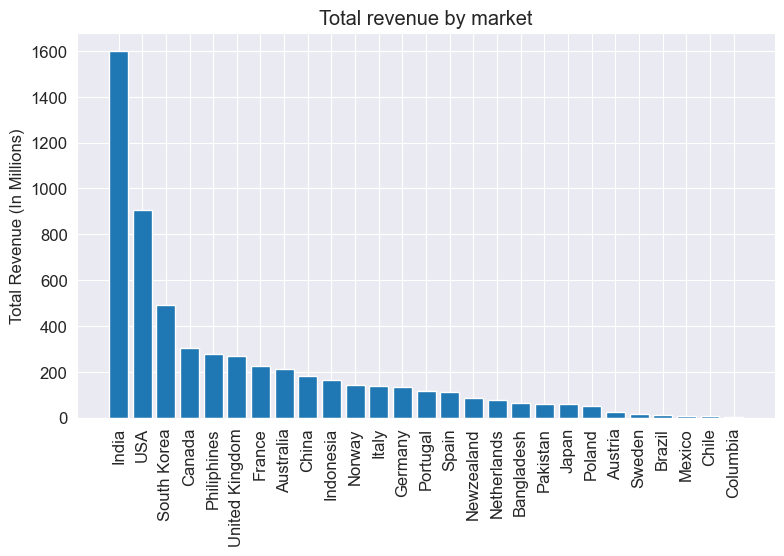

In [15]:
plt.bar(df3.market,df3.total_revenue)
plt.ylabel("Total Revenue (In Millions)")
plt.title("Total revenue by market")
plt.xticks(df3.market,df3.market,rotation=90)
plt.show()

We can see that `India` and `USA` are the biggest markets for AtliQ Hardwares.

In [16]:
# comparison of revenue by markets for the fiscal year 2022 and 2021
query1='''
select market, round(sum(revenue)/1000000,2) as total_revenue_2022
from monthly_revenue
join dim_customer
using(customer_code)
where fiscal_year=2022
group by 1
order by 2 desc
'''
query2='''
select market, round(sum(revenue)/1000000,2) as total_revenue_2021
from monthly_revenue
join dim_customer
using(customer_code)
where fiscal_year=2021
group by 1
order by 2 desc
'''
df4=pd.read_sql(query1,cnx)
df5=pd.read_sql(query2,cnx)
df4['total_revenue_2021']=df5.total_revenue_2021
df4.head()

,market,total_revenue_2022,total_revenue_2021
0,India,909.91,455.05
1,USA,506.48,264.46
2,South Korea,271.13,131.86
3,Canada,174.07,89.78
4,United Kingdom,161.10,80.64


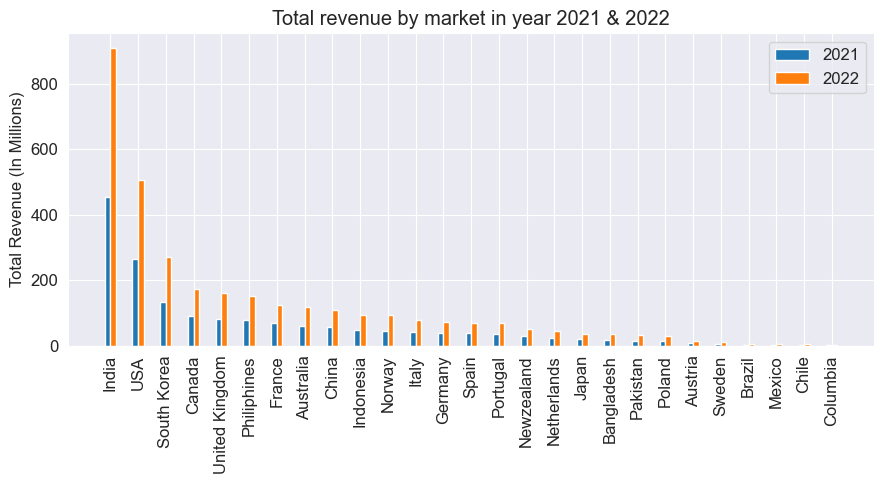

In [17]:
#revenue comparison by markets for the fiscal_year 2022 and 2021
width=0.20
x = np.arange(len(df4.market))
plt.bar(x-width/2,df4.total_revenue_2021,width,label='2021')
plt.bar(x+width/2,df4.total_revenue_2022,width,label='2022')
plt.ylabel("Total Revenue (In Millions)")
plt.title("Total revenue by market in year 2021 & 2022")
plt.xticks(x,df4.market,rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The sudden increase in revenue in fiscal year 2022 can be seen in every market around the globe.

In [18]:
#lowest performers for the fiscal_year 2021 and 2022
df4.tail(5)

,market,total_revenue_2022,total_revenue_2021
22,Sweden,9.50,4.40
23,Brazil,4.31,2.30
24,Mexico,4.04,2.14
25,Chile,3.31,1.46
26,Columbia,0.83,0.37


In [19]:
# which products generated most revenue till now
query='''
select product, category, round(sum(revenue)/1000000,2) as total_revenue_mln,
	round(sum(sold_quantity)/1000,2) as total_quantity_thsnd
from monthly_revenue
join dim_product
using(product_code)
group by 1,2
order by 3 desc
'''
df5=pd.read_sql(query,cnx)
df5.head()

,product,category,total_revenue_mln,total_quantity_thsnd
0,AQ BZ Allin1,Business Laptop,185.61,252.78
1,AQ BZ Compact,Business Laptop,183.83,397.86
2,AQ Smash 1,Gaming Laptop,181.44,280.96
3,AQ Smash 2,Gaming Laptop,175.83,251.32
4,AQ Gamer 2,Gaming Laptop,173.70,284.05


The business laptop model `AQ BZ Allin 1` generated the highest revenue till now for AtliQ hardwares.

In [20]:
# which product sold the most number of times and also least number of times
r1=df5[df5.total_quantity_thsnd==max(df5.total_quantity_thsnd)]
r2=df5[df5.total_quantity_thsnd==min(df5.total_quantity_thsnd)]
f=[r1,r2]
r3=pd.concat(f)
r3

,product,category,total_revenue_mln,total_quantity_thsnd
59,AQ Master wired x1 Ms,Mouse,29.37,6856.64
14,AQ Home Allin1,Personal Desktop,131.90,161.05


However, the mouse model `AQ Master wired x1 Ms` was sold most number of times.

In [21]:
# which product sold most in the fiscal_year 2022
query='''
select product,category, round(sum(sold_quantity)/1000,2) as total_quantity_thsnd
from monthly_revenue
join dim_product
using(product_code)
where fiscal_year=2022
group by 1,2
order by 3 desc
limit 1
'''
cursor.execute(query)
r4=cursor.fetchall()
print("{} which is a {} was sold most in the fiscal year 2022.".format(r4[0][0],r4[0][1]))

AQ Mforce Gen Z which is a Graphic Card was sold most in the fiscal year 2022.


In [22]:
# which product generated most revenue in the fiscal_year 2022
query='''
select product,category, round(sum(revenue)/1000000,2) as total_revenue_mln
from monthly_revenue
join dim_product
using(product_code)
where fiscal_year=2022
group by 1,2
order by 3 desc
limit 1
'''
cursor.execute(query)
r4=cursor.fetchall()
print("{} which is a {} generated the most revenue in the fiscal year 2022.".format(r4[0][0],r4[0][1]))

AQ BZ Allin1 Gen 2 which is a Business Laptop generated the most revenue in the fiscal year 2022.


In [23]:
# which product segement got sold most in total
query='''
select segment, round(sum(sold_quantity)/1000,2) as total_quantity_thsnd
from monthly_revenue
join dim_product
using(product_code)
group by 1
order by 2 desc
'''
df6=pd.read_sql(query,cnx)
df6

,segment,total_quantity_thsnd
0,Accessories,72992.02
1,Peripherals,22706.40
2,Storage,17195.95
3,Networking,6620.09
4,Notebook,4957.46
5,Desktop,819.64


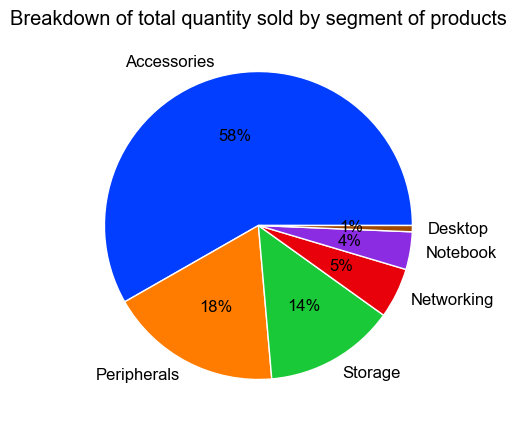

In [24]:
fig = plt.figure()
fig.patch.set_facecolor('white')
palette_color=sns.color_palette('bright')
plt.rcParams['text.color'] = 'black'
plt.pie(df6.total_quantity_thsnd, labels=df6.segment, colors=palette_color, autopct='%.0f%%')
plt.title('Breakdown of total quantity sold by segment of products')
plt.show()

In [ ]:
# created a table for monthly net revenue after total deductions
query='''
create table `fact_net_profit`
with cte1 as (
select m.*,
	revenue*(r1.pre_invoice_discount_pct+r2.discounts_pct+r2.other_deductions_pct+r5.freight_pct+r5.other_cost_pct)+r3.manufacturing_cost as total_deduction
from monthly_revenue m
left join fact_pre_invoice_deductions r1
using(customer_code, fiscal_year)
left join fact_post_invoice_deductions r2
using(customer_code, product_code, date)
left join fact_manufacturing_cost r3
on m.product_code=r3.product_code and m.fiscal_year=r3.cost_year
left join dim_customer r4
using(customer_code)
left join fact_freight_cost r5
using(market, fiscal_year))

select *, revenue-total_deduction as net_revenue
from cte1
'''
cursor.execute(query)
temp=cursor.fetchall()

The total deductions from the revenue includes `pre invoice deductions` like special discount to the customer for relationship, `post invoice deductions` like discounts on the products already on sale, `freight cost` which is different for different regions, `manufacturing cost`.

In [26]:
#The total net profit for each fiscal year
query='''
select fiscal_year, round(sum(net_revenue)/1000000,2) as total_profit
from fact_net_profit
group by 1
order by 1
'''
temp_df=pd.read_sql(query,cnx)
temp_df

,fiscal_year,total_profit
0,2018,21.18
1,2019,83.46
2,2020,192.65
3,2021,598.06
4,2022,1264.49


In [27]:
#comparison between the total revenue and total net revenue after all the deductions
df1['net_revenue_mln']=temp_df.total_profit
df1

,fiscal_year,total_sold_quantity_in_millions,total_revenue_in_millions,net_revenue_mln
0,2018,3.45,58.32,21.18
1,2019,10.78,209.06,83.46
2,2020,20.77,535.95,192.65
3,2021,50.16,1664.64,598.06
4,2022,40.11,3258.68,1264.49


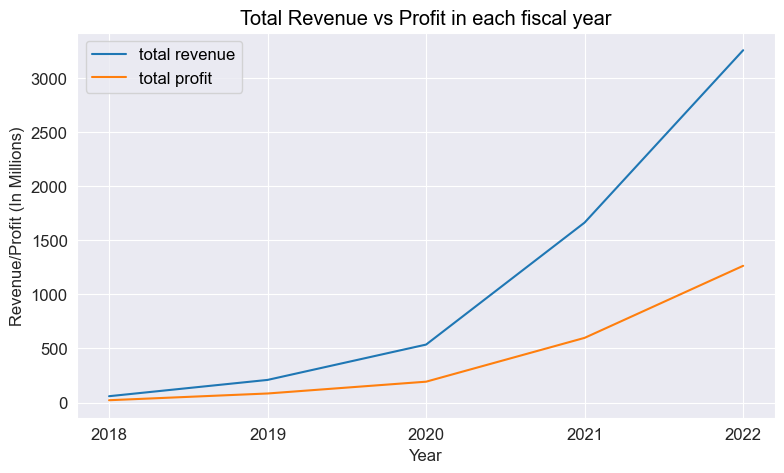

In [28]:
plt.plot(df1.fiscal_year,df1.total_revenue_in_millions,label='total revenue')
plt.plot(df1.fiscal_year,df1.net_revenue_mln,label='total profit')
plt.title('Total Revenue vs Profit in each fiscal year')
plt.xlabel('Year'); plt.ylabel('Revenue/Profit (In Millions)');
plt.xticks(df1.fiscal_year, df1.fiscal_year)
plt.legend()
plt.show()

In [29]:
# which customer generated maximum revenue and maximum profit
query1='''
with cte1 as (select customer, sum(revenue) as revenue1
    from monthly_revenue
    join dim_customer
    using(customer_code)
    group by 1),
    cte2 as (select customer, dense_rank() over(order by revenue1 desc) as rnk
    from cte1)
select customer
from cte2
where rnk=1
'''

query2='''
with cte1 as (select customer, sum(net_revenue) as revenue1
    from fact_net_profit
    join dim_customer
    using(customer_code)
    group by 1),
    cte2 as (select customer, dense_rank() over(order by revenue1 desc) as rnk
    from cte1)
select customer
from cte2
where rnk=1
'''

cursor.execute(query1)
r5=cursor.fetchall()
cursor.execute(query2)
r6=cursor.fetchall()
print("The customer with maximum net revenue is {} and with maximum net profit is {}.".format(r5[0][0],r6[0][0]))

The customer with maximum net revenue is Amazon  and with maximum net profit is Amazon .


In [30]:
#which customer generated maximum revenue and maximum profit in the fiscal_year 2020
query1='''
with cte1 as (select customer, sum(revenue) as revenue1, sum(net_revenue) as revenue2
    from fact_net_profit
    join dim_customer
    using(customer_code)
    where fiscal_year=2020
    group by 1),
    cte2 as (select customer, dense_rank() over(order by revenue1 desc) as rnk, dense_rank() over(order by revenue2 desc) as drnk
    from cte1)
select customer
from cte2
where rnk=1 or drnk=1
order by rnk
'''

cursor.execute(query1)
r5=cursor.fetchall()
print("The customer with maximum net revenue is {} and with maximum net profit is {}.".format(r5[0][0],r5[0][0]))

The customer with maximum net revenue is Amazon and with maximum net profit is Amazon.


In [31]:
#total contribution in profit by market

query='''
select market, round(sum(net_revenue)/1000000,2) as revenue1
from fact_net_profit
join dim_customer
using(customer_code)
where fiscal_year=2022
group by market
order by 1
'''
temp2=pd.read_sql(query,cnx)
temp2.head()

,market,revenue1
0,Australia,56.17
1,Austria,3.88
2,Bangladesh,11.25
3,Brazil,1.06
4,Canada,87.44


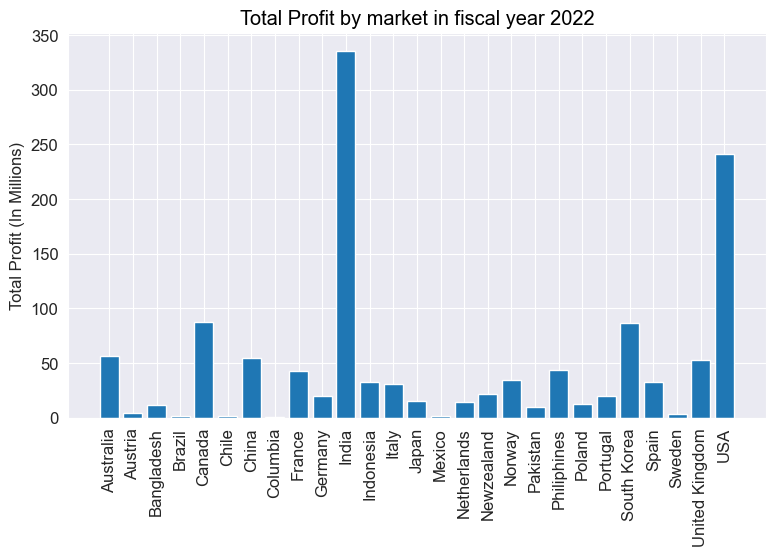

In [32]:
plt.bar(temp2.market,temp2.revenue1)
plt.ylabel("Total Profit (In Millions)")
plt.title("Total Profit by market in fiscal year 2022")
plt.xticks(temp2.market,temp2.market,rotation=90)
plt.show()

We can see that `India` and `USA` are eminent markets for AtliQ hardwares.

In [33]:
#total contribution in profit by product division in fiscal year 2022

query='''
select division, round(sum(net_revenue)/1000000,2) as revenue1
from fact_net_profit
join dim_product
using(product_code)
where fiscal_year=2022
group by 1
order by 1
'''
temp2=pd.read_sql(query,cnx)
temp2.head()

,division,revenue1
0,N & S,33.61
1,P & A,494.18
2,PC,736.70


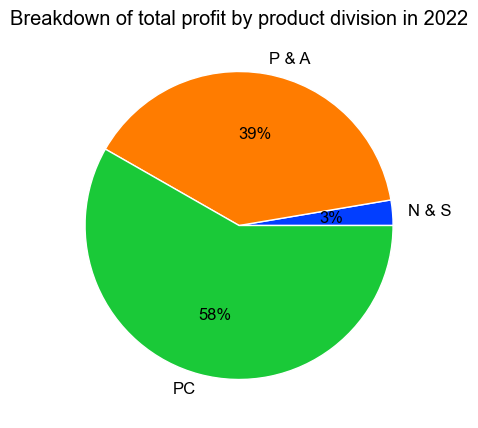

In [34]:
fig = plt.figure()
fig.patch.set_facecolor('white')
palette_color=sns.color_palette('bright')
plt.rcParams['text.color'] = 'black'
plt.pie(temp2.revenue1, labels=temp2.division, colors=palette_color, autopct='%.0f%%')
plt.title('Breakdown of total profit by product division in 2022')
plt.show()

In [35]:
# loss or no profit sections
query='''
select market,sum(abs(forecast_quantity-cast(sold_quantity as signed)))/sum(sold_quantity) as forecast_error_pct
from fact_sales_monthly
join fact_forecast_monthly
using (date, product_code, customer_code)
join dim_customer
using(customer_code)
group by 1
order by 1
'''
forecast_df=pd.read_sql(query,cnx)
forecast_df

,market,forecast_error_pct
0,Australia,0.6667
1,Austria,0.5646
2,Bangladesh,0.6455
3,Brazil,0.6813
4,Canada,0.6640
5,Chile,0.5638
6,China,0.6140
7,Columbia,0.6210
8,France,0.6453
9,Germany,0.5779


We can see that the forecast error percentage for each market is nearly `60%`. Higher forecat error results in high warehouse/keeping charges which eventaully affects the profit of the firm.

### Conclusion

The revenue of the AtliQ Hardwares is increasing drastically which is a positive side. The revenue sky rockets in the fiscal year 2022 even with less number of items sold in comparison to the previous fiscal year 2021. The PC division of the products generated the most profit accounting a whooping 58% of the total profit. <br>
However, the forecast for each market is not efficient as it should be.